# Survival Analysis – Chlorhexidine Trial

This notebook performs a basic survival analysis on the Chlorhexidine trial data.

It:
- Builds **time-to-VAP** using CPIS scores and outcome labels.
- Plots **Kaplan–Meier** curves by treatment arm.
- Performs a **log-rank test**.
- Fits a simple **Cox Proportional Hazards model**.



In [21]:
# 1. Install and import libraries

!pip install lifelines openpyxl --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

sns.set_palette("muted")
plt.style.use("default")


## 2. Load the dataset

Make sure the Excel file is named:

`Data form Chlorhexidine Trial.xlsx`

and is uploaded in the same folder (for Jupyter) or into the Colab session.


In [22]:
# 2. Loading the data

file_path = "Data form Chlorhexidine Trial.xlsx"
df_raw = pd.read_excel(file_path)

print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (106, 85)


,Trial Arm,Age,Gender,Outcome of the current episode,Outcome of current episode 2,APACHE II Score,TLC Day 1,TLC Day 2,TLC Day 3,TLC Day 4,...,Ulcer Day 2,Ulcer Day 3,Ulcer Day 4,Ulcer Day 5,Ulcer Day 6,Ulcer Day 7,Ulcer Day 8,Ulcer Day 9,Ulcer Day 10,Day 1
0,Group 1,49,Male,No VAP,Discharged,11.0,11900.0,12600.0,10900.0,10400.0,...,Negative,Negative,Negative,Negative,NaN,NaN,NaN,NaN,NaN,NaN
1,Group 1,72,Male,No VAP,Discharged,17.0,16800.0,17800.0,12400.0,9300.0,...,Negative,Negative,Negative,Negative,Negative,NaN,NaN,NaN,NaN,NaN
2,Group 1,72,Male,No VAP,Death,16.0,23300.0,46600.0,39200.0,27800.0,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,NaN,NaN,NaN
3,Group 1,55,Female,No VAP,Discharged,29.0,9500.0,9500.0,9400.0,11400.0,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,NaN
4,Group 1,20,Male,No VAP,LAMA,18.0,7000.0,10900.0,11800.0,7400.0,...,Negative,Negative,Negative,Negative,Negative,NaN,NaN,NaN,NaN,NaN


## 3. Identify CPIS Day columns

We will detect all columns named like `CPIS Day 1`, `CPIS Day 2`, ..., and sort them by day number.


In [23]:
# 3. Identify CPIS Day columns

cpis_cols = []
for col in df_raw.columns:
    if isinstance(col, str) and col.startswith("CPIS Day"):
        cpis_cols.append(col)

def get_day(col_name: str) -> int:
    m = re.search(r"(\d+)$", col_name)
    return int(m.group(1)) if m else 999

cpis_cols = sorted(cpis_cols, key=get_day)

print("CPIS columns:", cpis_cols)


CPIS columns: ['CPIS Day 1', 'CPIS Day 2', 'CPIS Day 3', 'CPIS Day 4', 'CPIS Day 5', 'CPIS Day 6', 'CPIS Day 7', 'CPIS Day 8', 'CPIS Day 9', 'CPIS Day 10']


## 4. Functions Explained herein

We define two functions:

- `first_cpis_ge_threshold`: first day CPIS ≥ 6  
- `last_cpis_non_missing`: last day CPIS is recorded  


In [24]:
# 4. Functions

def first_cpis_ge_threshold(row, cols, threshold=6):
    """Return first day where CPIS >= threshold, else None."""
    for col in cols:
        val = row[col]
        if pd.notnull(val) and val >= threshold:
            return get_day(col)
    return None

def last_cpis_non_missing(row, cols):
    """Return last day with non-missing CPIS, or 0 if none."""
    last = 0
    for col in cols:
        if pd.notnull(row[col]):
            last = get_day(col)
    return last


## 5. Build survival variables (time + event) – Hybrid logic

**Event (`vap_event`)** is defined as:

- 1 if `Outcome of the current episode` is **VAP** (confirmed), or  
- 1 if CPIS ≥ 6 on any day (high-risk pattern),  
- 0 otherwise.

**Time (`time`)** is defined as:

- first day CPIS ≥ 6 if present, else  
- last day with recorded CPIS.

Patients with no CPIS data (time = 0) are excluded.


In [25]:
# 5. Building survival variables

df = df_raw.copy()

# Outcome-based event
df["event_from_outcome"] = (df["Outcome of the current episode"] == "VAP").astype(int)

# CPIS-based days
df["cpis_event_day"] = df.apply(
    lambda r: first_cpis_ge_threshold(r, cpis_cols, threshold=6),
    axis=1
)
df["cpis_last_day"] = df.apply(
    lambda r: last_cpis_non_missing(r, cpis_cols),
    axis=1
)

# CPIS-based event (1 if CPIS ever >= 6)
df["event_from_cpis"] = df["cpis_event_day"].notnull().astype(int)

# Hybrid event
df["vap_event"] = df["event_from_outcome"].where(
    df["event_from_outcome"] == 1,
    df["event_from_cpis"]
)

# Time
def compute_time(row):
    if pd.notnull(row["cpis_event_day"]):
        return int(row["cpis_event_day"])
    else:
        return int(row["cpis_last_day"])

df["time"] = df.apply(compute_time, axis=1)

# Filter to those with time > 0
surv = df[df["time"] > 0].copy()

print("Patients with usable survival data:", surv.shape[0])
surv[[
    "Outcome of the current episode",
    "event_from_outcome",
    "event_from_cpis",
    "vap_event",
    "cpis_event_day",
    "cpis_last_day",
    "time"
]].head(10)


Patients with usable survival data: 103


,Outcome of the current episode,event_from_outcome,event_from_cpis,vap_event,cpis_event_day,cpis_last_day,time
0,No VAP,0,0,0,NaN,5,5
1,No VAP,0,0,0,NaN,6,6
2,No VAP,0,0,0,NaN,8,8
3,No VAP,0,0,0,NaN,10,10
4,No VAP,0,0,0,NaN,6,6
5,No VAP,0,0,0,NaN,10,10
6,No VAP,0,0,0,NaN,3,3
7,No VAP,0,0,0,NaN,5,5
8,No VAP,0,0,0,NaN,10,10
9,No VAP,0,0,0,NaN,7,7


## 6. Encode trial Arm


In [26]:
# 6. Encode trial arm and basic info

surv["arm_label"] = surv["Trial Arm"].map({
    "Group 1": "CHX 0.12%",
    "Group 2": "CHX 0.20%"
})

surv["arm_binary"] = surv["Trial Arm"].map({
    "Group 1": 0,
    "Group 2": 1
})

print("Trial arm counts:")
print(surv["arm_label"].value_counts())

print("\nEvent counts (vap_event):")
print(surv["vap_event"].value_counts())

print("\nTime summary (days):")
print(surv["time"].describe())


Trial arm counts:
arm_label
CHX 0.12%    59
CHX 0.20%    44
Name: count, dtype: int64

Event counts (vap_event):
vap_event
0    93
1    10
Name: count, dtype: int64

Time summary (days):
count    103.000000
mean       5.815534
std        2.329468
min        1.000000
25%        4.000000
50%        6.000000
75%        7.000000
max       10.000000
Name: time, dtype: float64


## 7. Kaplan–Meier survival curves


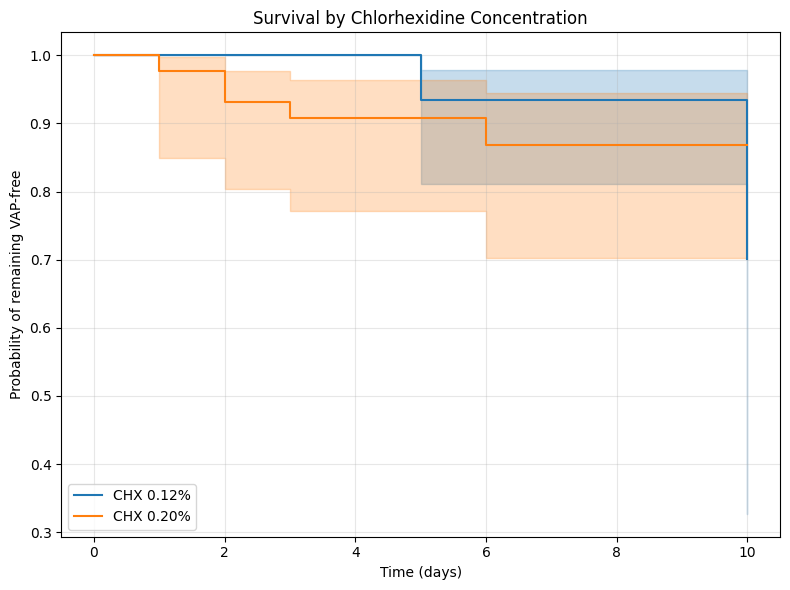

Estimated VAP-free probability at day 3: 0.961
Estimated VAP-free probability at day 5: 0.922
Estimated VAP-free probability at day 7: 0.904
Estimated VAP-free probability at day 10: 0.775


In [27]:
# 7. Kaplan–Meier curves

kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))
for label, group_df in surv.groupby("arm_label"):
    kmf.fit(group_df["time"], event_observed=group_df["vap_event"], label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title("Survival by Chlorhexidine Concentration")
plt.xlabel("Time (days)")
plt.ylabel("Probability of remaining VAP-free")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Overall VAP-free estimates at selected days
kmf.fit(surv["time"], event_observed=surv["vap_event"])
for d in [3, 5, 7, 10]:
    try:
        print(f"Estimated VAP-free probability at day {d}: {kmf.predict(d):.3f}")
    except:
        pass


## 8. Log-rank test between CHX 0.12% and 0.20%


In [28]:
# 8. Log-rank test

arm0 = surv[surv["arm_binary"] == 0]
arm1 = surv[surv["arm_binary"] == 1]

logrank_res = logrank_test(
    arm0["time"], arm1["time"],
    event_observed_A=arm0["vap_event"],
    event_observed_B=arm1["vap_event"]
)

print("=== Log-rank test: CHX 0.12% vs 0.20% ===")
logrank_res.print_summary()


=== Log-rank test: CHX 0.12% vs 0.20% ===


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.34 0.56      0.84

## 9. Cox Proportional Hazards model (simple)


Rows used for Cox model: 103


<lifelines.CoxPHFitter: fitted with 103 total observations, 93 right-censored observations>
             duration col = 'time'
                event col = 'vap_event'
      baseline estimation = breslow
   number of observations = 103
number of events observed = 10
   partial log-likelihood = -39.36
         time fit was run = 2025-11-24 18:50:03 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
arm_binary       0.42      1.53      0.71           -0.96            1.81                0.38                6.10
Age              0.00      1.00      0.02           -0.04            0.04                0.96                1.04
APACHE II Score -0.06      0.94      0.05           -0.16            0.04                0.85                1.04
male             0.42      1.52      1.14           -1.81            2.65                0.16               14.09

                 cmp to     z    p  -log2(p)
covariate                                   
arm_binary         0.00  0.60 0.55      0.87
Age                0.00  0.10 0.92      0.13
APACHE II Score    0.00 -1.24 0.21      2.22
male               0.00  0.37 0.71      0.49
---
Concordance = 0.68
Partial AIC = 86.71
log-likelihood ratio test = 2.22 on 4 df
-log2(p) of ll-ratio test = 0.52

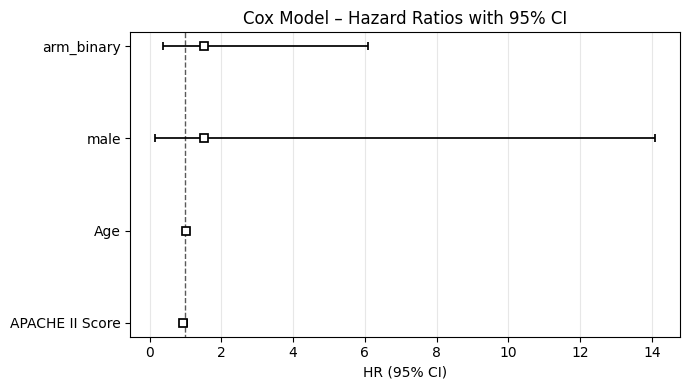

In [29]:
# 9. Cox PH model

cox_df = surv[[
    "time",
    "vap_event",
    "arm_binary",
    "Age",
    "APACHE II Score",
    "Gender"
]].copy()

# Encode gender: Male = 1, others = 0
cox_df["male"] = np.where(cox_df["Gender"].str.lower() == "male", 1, 0)

# Drop rows with missing covariates
cox_df = cox_df.dropna(subset=["time", "vap_event", "arm_binary", "Age", "APACHE II Score", "male"])

print("Rows used for Cox model:", len(cox_df))

cph = CoxPHFitter()
cph.fit(
    cox_df[["time", "vap_event", "arm_binary", "Age", "APACHE II Score", "male"]],
    duration_col="time",
    event_col="vap_event"
)

cph.print_summary()

plt.figure(figsize=(7, 4))
cph.plot(hazard_ratios=True)
plt.title("Cox Model – Hazard Ratios with 95% CI")
plt.grid(alpha=0.3, axis="x")
plt.tight_layout()
plt.show()



   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 103 total observations, 93 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic    p  -log2(p)
APACHE II Score km              0.08 0.78      0.36
                rank            0.00 0.97      0.04
Age             km              0.05 0.83      0.28
                rank            0.03 0.86      0.22
arm_binary      km              6.23 0.01      6.32
                rank            4.45 0.03      4.84
male            km              1.98 0.16      2.65
                rank            0.30 0.58      0.77



1. Variable 'arm_binary' failed the non-proportional test: p-value is 0.0125.

   Advice: with so few unique values (only 2), you can include `strata=['arm_binary', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20ha

[[<Axes: xlabel='rank-transformed time\n(p=0.0349)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0125)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8576)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8260)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9702)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7776)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5847)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1590)'>]]

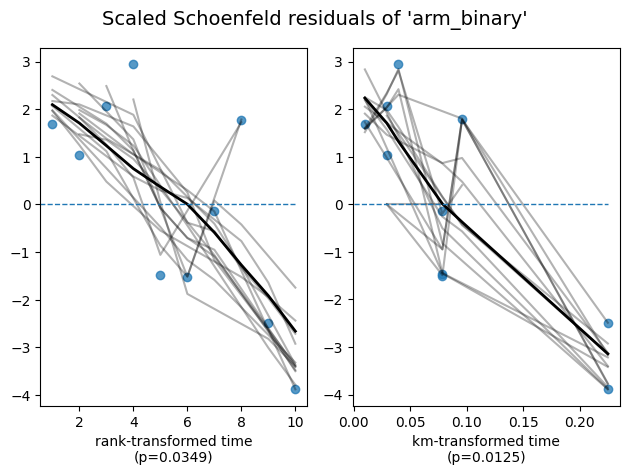

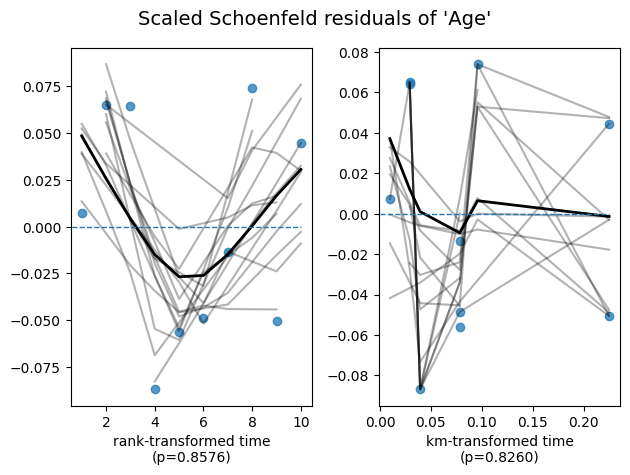

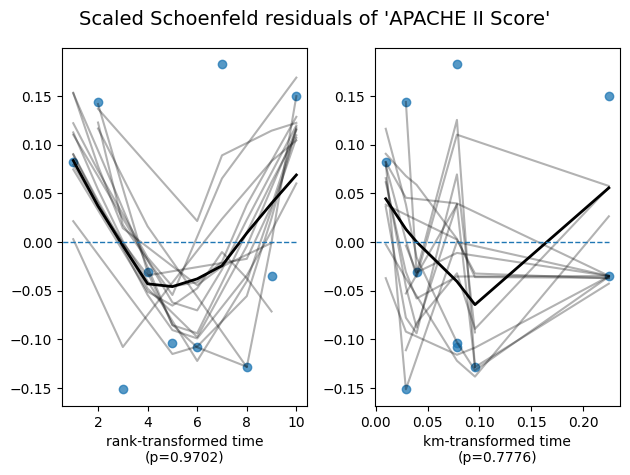

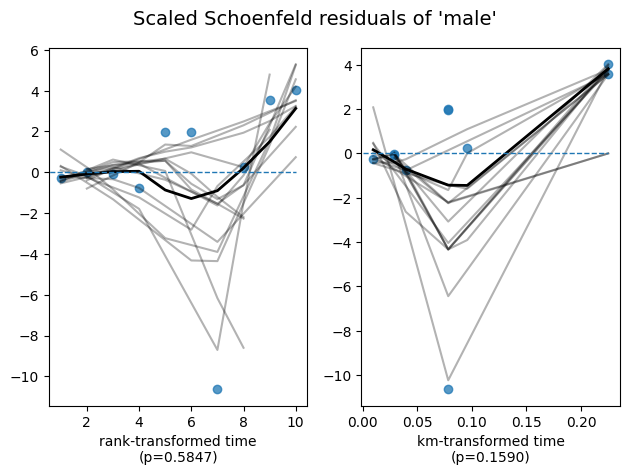

In [30]:
##9. Proportional Hazards assumption check

cph.check_assumptions(
    cox_df[["time", "vap_event", "arm_binary", "Age", "APACHE II Score", "male"]],
    show_plots=True,
    p_value_threshold=0.05
)